# Selecting Ridge Regression Model with K-Fold CV

In the attached workspace, you will use K-fold CV to select the regularization strength in an L2-regularized regression model. Then, you will fit the optimal model and evaluate its accuracy on a test set not used for model fitting.

You'll need to specify this random state in your notebook:

> random_state = 13

| Name	| Type	| Description |
| --- | --- | --- |
|`Xtr_df`| pandas data frame	| Training data (features).|
|`Xts_df`| pandas data frame	| Test data (features).|
|`ytr_df`| pandas data frame	| Training data (target).|
|`yts_df`| pandas data frame	| Test data (target).|
|`mse_mean`	| 1d numpy array	| The mean validation MSE for each model in the K-fold CV.|
|`alpha_min_mse`	| float	| The value of the tuning parameter alpha that yields the lowest MSE on the validation data.|
|`mse_ridge`	| float	| The test MSE for the best Ridge regression model.|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

In this notebook, we are interested in predicting the price of a diamond from its physical characteristics.

First, load in the data:

In [2]:
df = pd.read_csv('diamonds.csv')

Get a quick view of the columns in this data by runnning the cell below. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


This dataset contains information about 53,940 round-cut diamonds. It includes variables measuring various pieces of information about the diamonds. 

There are 3 variables that are ordered categorical values: `cut`, `color`, & `clarity`.

* `cut` can be, from worst to best: Fair, Good, Very Good, Premium, Ideal
* `color` can range from J (worst) to D (best)
* `clarity` can be I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)

There are 6 variables that are numeric: `carat`, `depth`, `table`, `x`, `y`, `z`. These relate to the physical size of the diamond.

* `carat` is the weight of the diamond
* `depth` is the total depth percentage	
* `table` gives the width of top of diamond relative to widest point
* `x`, `y`, and `z` are the length, width, and depth in mm, respectively.


Finally, the `price` variable (which will be our target variable in this analysis) is also numeric, and gives the price of the diamond in US dollars.


The following cell maps the three categorical variables to numeric equivalents according to their order, so that we can use them in our regression.

In [4]:
df["cut"] = df["cut"].map({"Fair": 1, "Good": 2, "Very Good": 3, "Premium": 4, "Ideal": 5})
df["color"] = df["color"].map({"J": 1, "I": 2, "H": 3, "G": 4, "F": 5, "E": 6, "D": 7})
df["clarity"] = df["clarity"].map({"I1": 1, "SI2": 2, "SI1": 3, "VS2": 4, "VS1": 5, "VVS2": 6, "VVS1": 7, "IF": 8})

For convenience, the cell below will read the names of the columns we want to use as features into an array called `x_names`, and the name of the column we want to use as the target will be read into `y_names`.

In [5]:
x_names = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
y_names = ['price']

Using `df`, `x_names`, and `y_names`, split the data into training and test sets using `sklearn`'s implementation of `train_test_split`. 

* Reserve 30% of the data for testing, and leave 70% for training.
* Shuffle the data, and use the random state specified in the PrairieLearn question page.

In [6]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
random_state = 13
Xtr_df, Xts_df = train_test_split(df[x_names], test_size=0.3, random_state=random_state, shuffle=True)
ytr_df, yts_df = train_test_split(df[y_names], test_size=0.3, random_state=random_state, shuffle=True)

The `sklearn` implementation of `train_test_split` will return `pandas` data frames, but we'll prefer to work with this data as `numpy` arrays. The following cell will convert the data frames to arrays.

In [7]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
Xtr = np.array(Xtr_df)
Xts = np.array(Xts_df)
ytr = np.array(ytr_df)
yts = np.array(yts_df)

With Ridge (L2 norm regularization), the hyperparameter $\alpha$ controls the "strength" regularization term in the objective function. We will evaluate Ridge models for the following values of $\alpha$:

In [8]:
alpha_list = np.array([0, 10, 20, 50, 100, 200, 500])

In the following cells, we are going to set up a K-fold CV to select a value of $\alpha$.  First, we will set up an array to hold the results of each model in each fold. (Note that our K-fold CV will use 5 folds.)

In [9]:
nfold = 5
mse_val = np.zeros((len(alpha_list), nfold))

Now, create a KFold object using the `sklearn` implementation. Use 5 folds (and don't shuffle the data inside the K-Fold CV, since it is already shuffled from the `train_test_split`).

When using a regularized model, we always standardize the data (remove the mean and scale to unit variance) first. In the "outer loop" (loop over folds), use the `sklearn` implementation of a `StandardScaler` to standardize the feature data (X). You should use the statistics of the training data *for that fold* to standardize both the training set and the validation set. 

Then, use the standardized validation data to evalute an `sklearn` `Ridge` regression model for each of the $\alpha$ values in `alpha_list`, and save the validation MSE inside `mse_val`. Leave all the `Ridge` hyperparameters and settings at their default values, expect for `alpha`.

In [10]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)

kf = KFold(n_splits=nfold, shuffle=False)

# For each fold, standardize the data
for ifold, (idx_tr, idx_val) in enumerate(kf.split(Xtr)):
    X_train_fold, X_val_fold = Xtr[idx_tr], Xtr[idx_val]
    y_train_fold, y_val_fold = ytr[idx_tr], ytr[idx_val]
    scaler = StandardScaler().fit(X_train_fold)
    X_train_fold_std = scaler.transform(X_train_fold)
    X_val_fold_std = scaler.transform(X_val_fold)
    
    # For each alpha in the list, fit a Ridge regression model on the standardized data
    for i, alpha in enumerate(alpha_list):
        model = Ridge(alpha=alpha)
        model.fit(X_train_fold_std, y_train_fold)
        y_pred = model.predict(X_val_fold_std)
        # update the appropriate entry in mse_val
        mse_val[i, ifold] = mean_squared_error(y_val_fold, y_pred)

Next, compute the mean validation MSE for each of the models, and identify the value of $\alpha$ for which the validation MSE is minimized.

In [11]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
mse_mean = np.mean(mse_val, axis=1)
alpha_min_mse = alpha_list[np.argmin(mse_mean)]

Visualize the results, and make sure the value you found is consistent with the visualization!

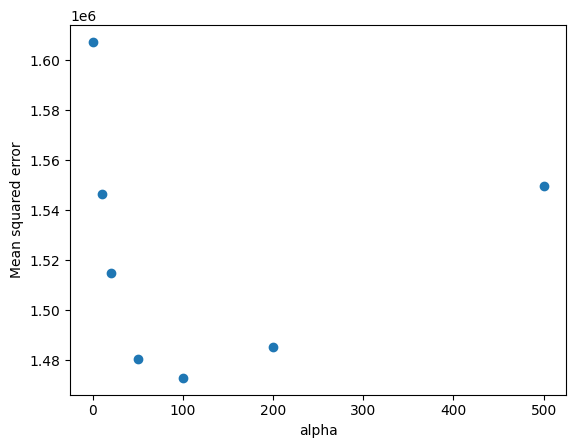

In [12]:
plt.scatter(alpha_list, mse_mean);
plt.xlabel("alpha");
plt.ylabel("Mean squared error");

Using the $\alpha$ value you identified in the previous step, standardize the training and test sets using the statistics of the *entire* training set. Then, fit a Ridge regression model on the entire standardized training data. Finally, compute the mean squared error on the standardized test data for this model.

In [13]:
#grade (write your code in this cell and DO NOT DELETE THIS LINE)
scaler = StandardScaler().fit(Xtr)
Xtr_std = scaler.transform(Xtr)
Xts_std = scaler.transform(Xts)
model = Ridge(alpha=alpha_min_mse)
model.fit(Xtr_std, ytr)
y_pred = model.predict(Xts_std)
mse_ridge = mean_squared_error(yts, y_pred)

In [14]:
mse_ridge

1529046.102275018